In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
train_ds, val_ds, test_ds = load_dataset(os.path.abspath('images'))

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим наши модели:

In [5]:
simple_model = tf.keras.models.load_model('ready_models/simple_model.keras')
inception_v3 = tf.keras.models.load_model('ready_models/inception_v3.keras')
resnet_50_v2 = tf.keras.models.load_model('ready_models/resnet_50_v2.keras')
mobile_net_v2 = tf.keras.models.load_model('ready_models/mobile_net_v2.keras')
xception = tf.keras.models.load_model('ready_models/xception.keras')
nas_net_mobile = tf.keras.models.load_model('ready_models/nas_net_mobile.keras')

simple_model._name = 'simple_model'
inception_v3._name = 'inception_v3'
resnet_50_v2._name = 'resnet_50_v2'
mobile_net_v2._name = 'mobile_net_v2'
xception._name = 'xception'
nas_net_mobile._name = 'nas_net_mobile'

2024-04-25 13:32:15.204146: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29491200 exceeds 10% of free system memory.
2024-04-25 13:32:15.298224: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29491200 exceeds 10% of free system memory.


Первая ансамблевая модель - усреднение результата предсказаний:

In [12]:
models = [simple_model, inception_v3, resnet_50_v2, mobile_net_v2, xception, nas_net_mobile]
model_input = tf.keras.Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model_avg = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model_avg.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=['accuracy'])
ensemble_model_avg.evaluate(test_ds)

93/93 [==============================] - 54s 475ms/step - loss: 0.8138 - accuracy: 0.8313


[0.8137856125831604, 0.8313171863555908]

Попробуем убрать нашу самую простую модель с 47% точностью и сравним результаты:

In [13]:
models = [inception_v3, resnet_50_v2, mobile_net_v2, xception, nas_net_mobile]
model_input = tf.keras.Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model_avg_2 = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model_avg_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             metrics=['accuracy'])
ensemble_model_avg_2.evaluate(test_ds)

93/93 [==============================] - 53s 465ms/step - loss: 0.7528 - accuracy: 0.8266


[0.7527583241462708, 0.8266128897666931]

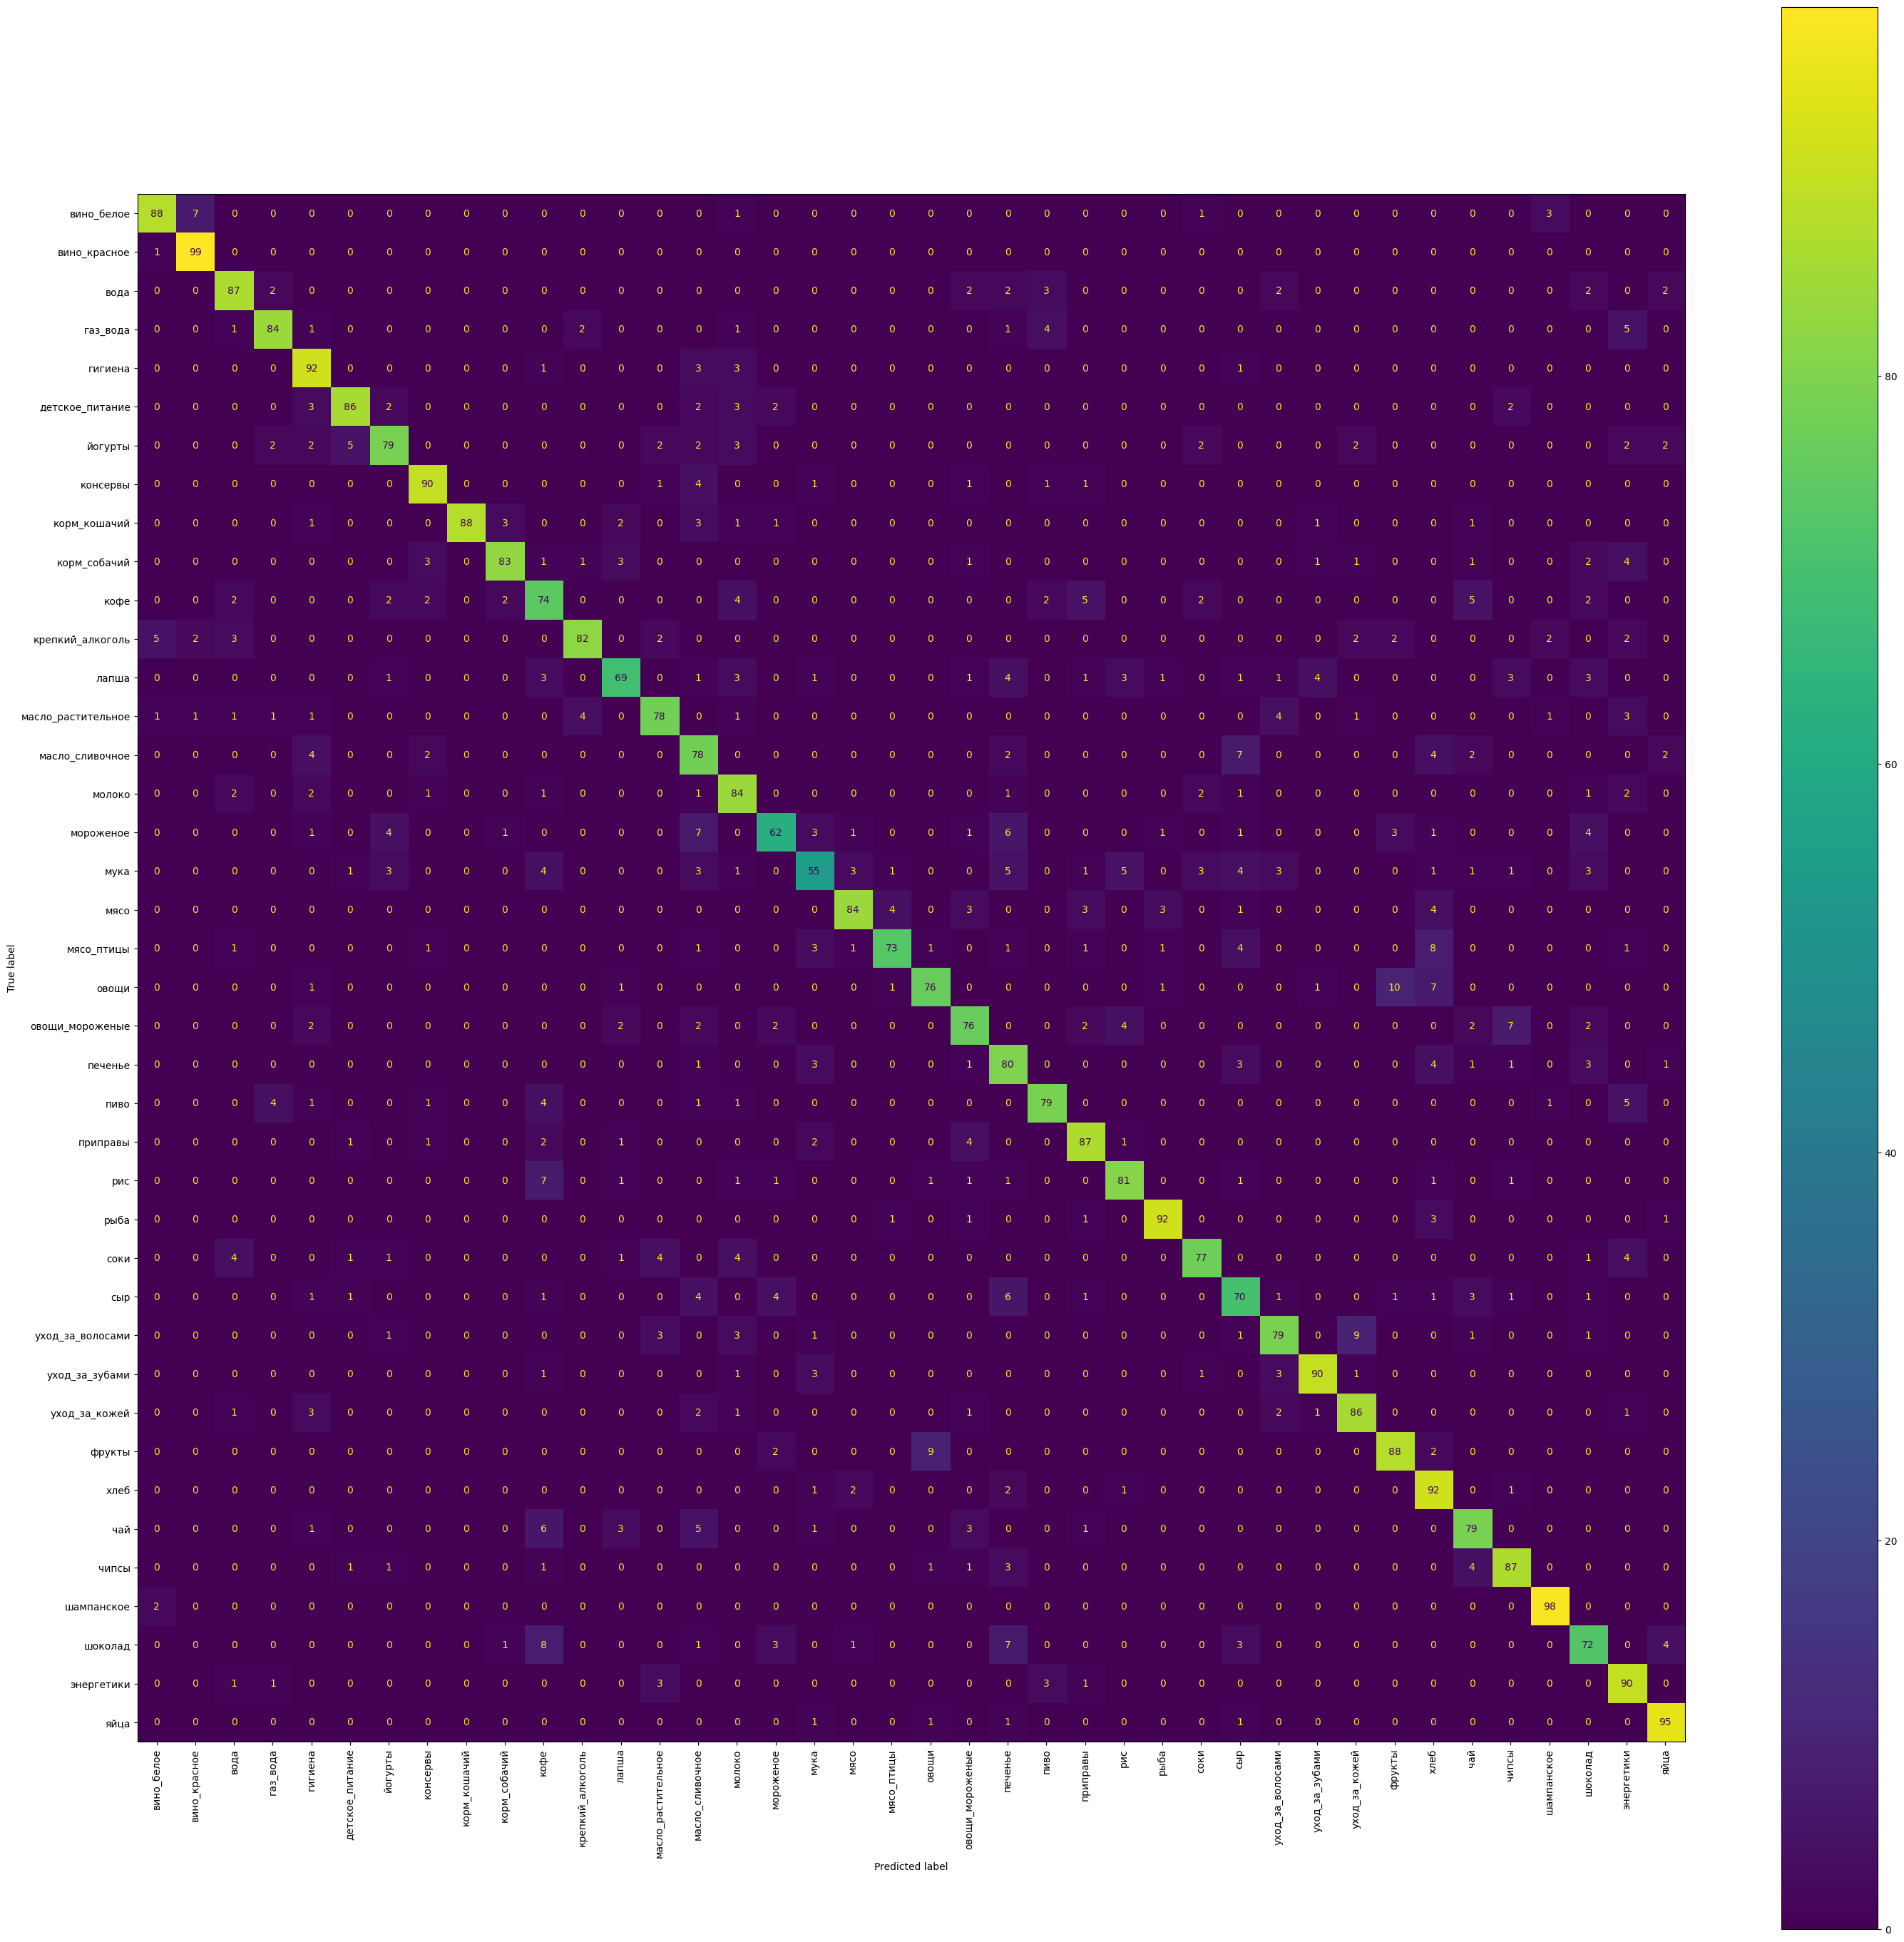

In [16]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(ensemble_model_avg, test_ds, train_ds.class_names)

In [15]:
ensemble_model_avg_2.save('ready_models/ensemble_model_avg.keras')